In [40]:
using Pkg
Pkg.activate("/home/users/shubhgup/Codes/Julia/TISExperiments.jl")

  Activating environment at `~/Codes/Julia/TISExperiments.jl/Project.toml`


In [41]:
using Revise

In [42]:
using POMDPs, POMDPGym, POMDPSimulators, POMDPPolicies, Distributions
using BSON
using SARSOP, Random
using POMCPOW
using BeliefUpdaters
using ParticleFilters
using FileIO
using TISExperiments
using POMDPGifs
using D3Trees
# using Interact
using TreeImportanceSampling
include("gridworld_mdp.jl")

In [43]:
using Plots
using ProgressMeter

In [44]:
adv_rewards, amdp = gen_gridworld_mdp(penalty_mul=1, maxT=20)

(Dict{SVector{2, Int64}, Float64}([10, 4] => 1.230999766183066, [6, 10] => 0.25268388016212295, [4, 5] => 0.4205550987639115, [6, 8] => 1.2270422445234832, [2, 3] => 0.42176969965313926, [10, 3] => 0.5639741650275885, [9, 6] => 1.7603781636265028, [5, 1] => 1.9178517526594696, [4, 2] => 1.204595160532766, [8, 7] => 0.2313753293494889…), RMDP{SVector{2, Int64}, Symbol}
  amdp: GridWorldMDP
  π: NoisyGridWorldPolicy NoisyGridWorldPolicy()
  cost_fn: costfn (function of type var"#costfn#35")
  include_time_in_state: Bool false
  dt: Int64 1
  maxT: Int64 20
  disturbance_type: Symbol action
)

In [45]:
# fixed_s = rand(initialstate(amdp))
fixed_s = SVector(4, 9)

2-element SVector{2, Int64} with indices SOneTo(2):
 4
 9

In [46]:
actions(amdp, fixed_s)

GenericDiscreteNonParametric([:up, :down, :left, :right], DiscreteNonParametric{Int64, Float64, Vector{Int64}, Vector{Float64}}(support=[1, 2, 3, 4], p=[0.003333333333333336, 0.003333333333333336, 0.003333333333333336, 0.99]))

In [48]:
N = 10_000

treeis_params = TreeImportanceSampling.TreeISParams(0.0, 1e-3, 0.0, 0.0, 1.0, 1e-6)

baseline = false
base_continue = false

path = "data/pendulum_topple";

if base_continue
    baseline_costs = load("$(path)_baseline_$(N).jld2")["risks"]
else
    baseline_costs = []
end


Any[]

In [50]:
# simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(actions(amdp, s))), fixed_s)

In [51]:
function heatmap_plot!(p, costs)
    xs = [i for i=1:10]
    ys = [i for i=1:10]
    C = fill(NaN, 10, 10)
    max_cost = max(values(costs)...)
    min_cost = min(values(costs)...)
    for (key, value) in costs
#         if 45<value<55
#             value = 1.5
#         elseif 95<value<105
#             value = 2
#         end
        C[key[1], key[2]] = value
    end
    heatmap!(p, xs, ys, C, clims=(min_cost, max_cost), c=:jet, alpha=0.3)
end

heatmap_plot! (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


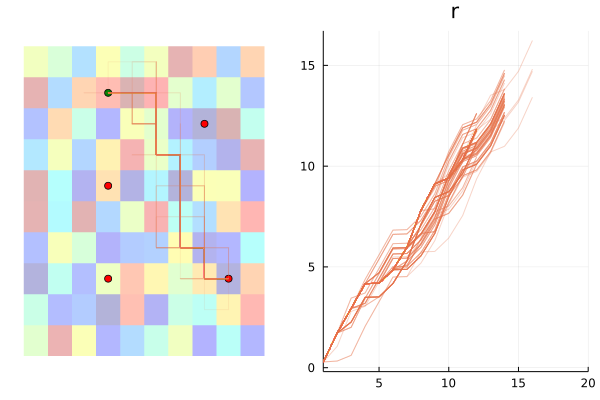

In [52]:
function plot_path(history; plots = [], idx=1)
    
    if length(plots)==0
        p = plot(xlim=(0, 11), ylim=(0, 11), legend=false, grid = false, axis=([], false))
        heatmap_plot!(p, adv_rewards)
        scatter!(p, [history[1].s[1]], [history[1].s[2]], color=:green)
        for s_term in amdp.amdp.g.terminate_from
            scatter!(p, [s_term[1]], [s_term[2]], color=:red)
        end
        push!(plots, p)
        
        p = plot(xlim = (1, amdp.maxT), title = "r", legend=false)
        push!(plots, p)
    end
    
    xs = [step.s[1] for step in history]
    ys = [step.s[2] for step in history]
    costs_l = cumsum([step.r for step in history])
#     @show xs, ys, costs_l
    plot!(plots[1], xs, ys, alpha=0.1, color=idx)
    
    plot!(plots[2], costs_l, alpha=0.3, color=idx)
    
    
    return plots
end
plots = []

@showprogress for i=1:1000
    history = simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(actions(amdp, s))), fixed_s);
    plots = plot_path(history; plots=plots, idx=2)
end
plot(plots...)

In [63]:
baseline_costs = gen_baseline_costs(amdp, fixed_s; N=10_000, N_seeds=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [ ]:
# p = histogram(plot_costs[1][2], label="$(plot_costs[1][1])", alpha=0.4, bins=100)
# for x in plot_costs[end:end]
#     histogram!(x[2], label="$(x[1])", alpha=0.4, bins=100)
# end
# p
max_cost = max(baseline_costs...)
histogram(baseline_costs, alpha=0.5, label="w/ disturbance", bins=0:max_cost/100:max_cost)
# histogram!(baseline_costs_1, alpha=0.5, label="w/o disturbance", bins=1:6:600)

In [60]:
# treeis_costs, treeis_logwts, stored_tree = update_treeis(amdp, fixed_s, treeis_params; N=1000, stored_tree=stored_tree);
treeis_costs, treeis_weights = gen_treeis_costs(amdp, fixed_s, treeis_params; N=N, N_seeds=10)

"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


([11.840950971546372 11.840950971546372 … 14.029662112692074 11.840950971546372; 11.840950971546372 11.840950971546372 … 14.993201305530635 14.993201305530635; … ; 11.840950971546372 11.840950971546372 … 11.840950971546372 13.507807155632902; 11.840950971546372 11.840950971546372 … 13.750367195756757 13.643511674553904], [1.0 1.0036677791923259 … 0.011125277377081284 1.8198001311941585; 1.0 1.0036677791923259 … 0.03883957443649726 0.038813019827450786; … ; 1.0 1.0036677791923259 … 1.588246202766025 0.0048008599834719525; 1.0 1.0036677791923259 … 0.003196990968044523 0.0028408793871285793])

In [59]:
lookup = TreeImportanceSampling.mdp_state_lookup(stored_tree[2])
# plots = []
@showprogress for i=1:1000
    history = simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> TreeImportanceSampling.tree_policy(stored_tree[2], s, lookup; params=treeis_params)), fixed_s);
    plots = plot_path(history; plots=plots, idx=3)
end
plot(plots...)
# planner.tree.cdf_est
# planner.tree.total_n
# planner.mdp.costs

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [ ]:
D3Tree(planner.tree.dpw_tree)

In [ ]:
plot(planner.mdp.IS_weights)

In [ ]:
tis_range = (1, length(tis_output[1]))
histogram(baseline_costs[tis_range[1]:tis_range[2]], alpha=0.5, label="MC", bins=0:1:100)
histogram!(planner.mdp.costs[tis_range[1]:tis_range[2]], alpha=0.5, label="Tree IS", bins=0:1:100)
# ylims!(0, 100)

In [ ]:

# print("Baseline metrics")

# TISExperiments.evaluate_metrics(baseline_costs; alpha_list=[1e-3])

# print("\nTIS metrics: N=$(N), c=$(c), α=$(α), β=$(β)), γ=$(γ)")

# TISExperiments.evaluate_metrics(tis_output[1][tis_range[1]:tis_range[2]]; weights=exp.(tis_output[3][tis_range[1]:tis_range[2]]), alpha_list=[1e-3])

# if baseline
# save("$(path)_baseline_$(N).jld2", Dict("risks" => baseline_costs, "states" => []))
# # else
# #     save("$(path)_mcts_IS_$(N).jld2", Dict("risks" => results_tis[1], "states" => results_tis[2], "IS_weights" => results_tis[3], "tree" => results_tis[4]))
# # end

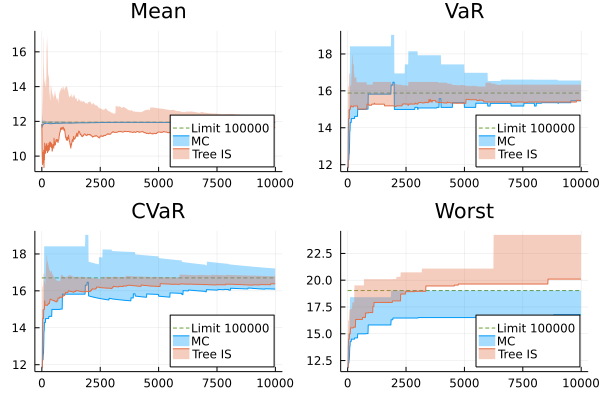

In [64]:
plots = TISExperiments.plot_metrics(baseline_costs, "MC", 1)
plots = TISExperiments.plot_metrics(treeis_costs, "Tree IS", 2; weights=treeis_weights, plots=plots)
plot(plots...)

In [ ]:
TISExperiments.plot_metrics([baseline_costs, baseline_costs, tis_output[1]]; weights_l=[nothing, nothing, exp.(tis_output[3])], range_l = tis_range, alpha=1e-3, names=["Limit", "MC", "Tree IS"], N_list = [2^i for i=1:10])